# How to call tools using ToolNode

This guide covers how to use LangGraph's prebuilt [`ToolNode`](/langgraphjs/reference/classes/langgraph_prebuilt.ToolNode.html) for tool calling.

`ToolNode` is a LangChain Runnable that takes graph state (with a list of messages) as input and outputs state update with the result of tool calls. It is designed to work well out-of-box with LangGraph's prebuilt ReAct agent, but can also work with any `StateGraph` as long as its state has a `messages` key with an appropriate reducer (see [`MessagesAnnotation`](/langgraphjs/concepts/low_level/#messagesannotation)).

## Setup

```bash
npm install @langchain/langgraph @langchain/anthropic @langchain/core zod
```

Set env vars:

```typescript
process.env.ANTHROPIC_API_KEY = 'your-anthropic-api-key';
```

## Define tools

In [1]:
import { tool } from '@langchain/core/tools';
import { z } from 'zod';

const getWeather = tool((input) => {
  if (['sf', 'san francisco'].includes(input.location.toLowerCase())) {
    return 'It\'s 60 degrees and foggy.';
  } else {
    return 'It\'s 90 degrees and sunny.';
  }
}, {
  name: 'get_weather',
  description: 'Call to get the current weather.',
  schema: z.object({
    location: z.string().describe("Location to get the weather for."),
  })
})

const getCoolestCities = tool(() => {
  return 'nyc, sf';
}, {
  name: 'get_coolest_cities',
  description: 'Get a list of coolest cities',
  schema: z.object({
    noOp: z.string().optional().describe("No-op parameter."),
  })
})

In [2]:
import { ToolNode } from '@langchain/langgraph/prebuilt';

const tools = [getWeather, getCoolestCities]
const toolNode = new ToolNode(tools)

## Manually call `ToolNode`

`ToolNode` operates on graph state with a list of messages. It expects the last message in the list to be an `AIMessage` with `tool_calls` parameter. 

Let's first see how to invoke the tool node manually:

In [3]:
import { AIMessage } from '@langchain/core/messages';

const messageWithSingleToolCall = new AIMessage({
  content: "",
  tool_calls: [
    {
      name: "get_weather",
      args: { location: "sf" },
      id: "tool_call_id",
      type: "tool_call",
    }
  ]
})

await toolNode.invoke({ messages: [messageWithSingleToolCall] })

{
  messages: [
    ToolMessage {
      "content": "It's 60 degrees and foggy.",
      "name": "get_weather",
      "additional_kwargs": {},
      "response_metadata": {},
      "tool_call_id": "tool_call_id"
    }
  ]
}


Note that typically you don't need to create `AIMessage` manually, and it will be automatically generated by any LangChain chat model that supports tool calling.

You can also do parallel tool calling using `ToolNode` if you pass multiple tool calls to `AIMessage`'s `tool_calls` parameter:

In [4]:
const messageWithMultipleToolCalls = new AIMessage({
  content: "",
  tool_calls: [
    {
      name: "get_coolest_cities",
      args: {},
      id: "tool_call_id",
      type: "tool_call",
    },
    {
      name: "get_weather",
      args: { location: "sf" },
      id: "tool_call_id_2",
      type: "tool_call",
    }
  ]
})

await toolNode.invoke({ messages: [messageWithMultipleToolCalls] })

{
  messages: [
    ToolMessage {
      "content": "nyc, sf",
      "name": "get_coolest_cities",
      "additional_kwargs": {},
      "response_metadata": {},
      "tool_call_id": "tool_call_id"
    },
    ToolMessage {
      "content": "It's 60 degrees and foggy.",
      "name": "get_weather",
      "additional_kwargs": {},
      "response_metadata": {},
      "tool_call_id": "tool_call_id_2"
    }
  ]
}


## Using with chat models

We'll be using a small chat model from Anthropic in our example. To use chat models with tool calling, we need to first ensure that the model is aware of the available tools. We do this by calling `.bindTools` method on `ChatAnthropic` model

In [5]:
import { ChatAnthropic } from "@langchain/anthropic";

const modelWithTools = new ChatAnthropic({
  model: "claude-3-haiku-20240307",
  temperature: 0
}).bindTools(tools);

In [6]:
const responseMessage = await modelWithTools.invoke("what's the weather in sf?");

responseMessage.tool_calls;

[
  {
    name: 'get_weather',
    args: { location: 'sf' },
    id: 'toolu_01UAjv9Mmj9LRosAsrgKtqeR',
    type: 'tool_call'
  }
]


As you can see, the AI message generated by the chat model already has `tool_calls` populated, so we can just pass it directly to `ToolNode`

In [7]:
await toolNode.invoke({ messages: [await modelWithTools.invoke("what's the weather in sf?")] })

{
  messages: [
    ToolMessage {
      "content": "It's 60 degrees and foggy.",
      "name": "get_weather",
      "additional_kwargs": {},
      "response_metadata": {},
      "tool_call_id": "toolu_01HrJmUek2ninxDiLJrYpDpz"
    }
  ]
}


## ReAct Agent

Next, let's see how to use `ToolNode` inside a LangGraph graph. Let's set up a graph implementation of the [ReAct agent](/langgraphjs/concepts/agentic_concepts/#react-agent). This agent takes some query as input, then repeatedly call tools until it has enough information to resolve the query. We'll be using `ToolNode` and the Anthropic model with tools we just defined

In [8]:
import {
  StateGraph,
  MessagesAnnotation,
  END,
  START
} from "@langchain/langgraph";

const toolNodeForGraph = new ToolNode(tools)

const shouldContinue = (state: typeof MessagesAnnotation.State) => {
    const { messages } = state;
    const lastMessage = messages[messages.length - 1];
    if ("tool_calls" in lastMessage && Array.isArray(lastMessage.tool_calls) && lastMessage.tool_calls?.length) {
        return "tools";
    }
    return END;
}

const callModel = async (state: typeof MessagesAnnotation.State) => {
    const { messages } = state;
    const response = await modelWithTools.invoke(messages);
    return { messages: [response] };
}


const workflow = new StateGraph(MessagesAnnotation)
    // Define the two nodes we will cycle between
    .addNode("agent", callModel)
    .addNode("tools", toolNodeForGraph)
    .addEdge(START, "agent")
    .addConditionalEdges(
        "agent",
        shouldContinue,
    )
    .addEdge("tools", "agent");

const app = workflow.compile()

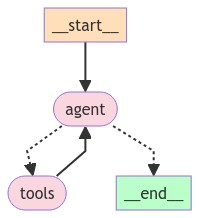

In [9]:
import * as tslab from "tslab";

const drawableGraph = app.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

Let's try it out!

In [10]:
import { HumanMessage } from "@langchain/core/messages";

// example with a single tool call
const stream = await app.stream(
  {
    messages: [{ role: "user", content: "what's the weather in sf?" }],
  },
  {
    streamMode: "values"
  }
)
for await (const chunk of stream) {
  const lastMessage = chunk.messages[chunk.messages.length - 1];
  const type = lastMessage._getType();
  const content = lastMessage.content;
  const toolCalls = lastMessage.tool_calls;
  console.dir({
    type,
    content,
    toolCalls
  }, { depth: null });
}

{
  type: 'human',
  content: "what's the weather in sf?",
  toolCalls: undefined
}
{
  type: 'ai',
  content: [
    { type: 'text', text: "Okay, let's check the weather in SF:" },
    {
      type: 'tool_use',
      id: 'toolu_01X5yTzVrGZqNz9vf1w2MCna',
      name: 'get_weather',
      input: { location: 'sf' }
    }
  ],
  toolCalls: [
    {
      name: 'get_weather',
      args: { location: 'sf' },
      id: 'toolu_01X5yTzVrGZqNz9vf1w2MCna',
      type: 'tool_call'
    }
  ]
}
{
  type: 'tool',
  content: "It's 60 degrees and foggy.",
  toolCalls: undefined
}
{
  type: 'ai',
  content: 'The current weather in San Francisco is 60 degrees and foggy.',
  toolCalls: []
}


In [11]:
// example with a multiple tool calls in succession
const streamWithMultiToolCalls = await app.stream(
  {
      messages: [{ role: "user", content: "what's the weather in the coolest cities?" }],
  },
  {
    streamMode: "values"
  }
)
for await (const chunk of streamWithMultiToolCalls) {
  const lastMessage = chunk.messages[chunk.messages.length - 1];
  const type = lastMessage._getType();
  const content = lastMessage.content;
  const toolCalls = lastMessage.tool_calls;
  console.dir({
    type,
    content,
    toolCalls
  }, { depth: null });
}

{
  type: 'human',
  content: "what's the weather in the coolest cities?",
  toolCalls: undefined
}
{
  type: 'ai',
  content: [
    {
      type: 'text',
      text: "Okay, let's find out the weather in the coolest cities:"
    },
    {
      type: 'tool_use',
      id: 'toolu_017RHcsJFeo7w6kDnZ6TAa19',
      name: 'get_coolest_cities',
      input: { noOp: 'dummy' }
    }
  ],
  toolCalls: [
    {
      name: 'get_coolest_cities',
      args: { noOp: 'dummy' },
      id: 'toolu_017RHcsJFeo7w6kDnZ6TAa19',
      type: 'tool_call'
    }
  ]
}
{ type: 'tool', content: 'nyc, sf', toolCalls: undefined }
{
  type: 'ai',
  content: [
    {
      type: 'text',
      text: "Now let's get the weather for those cities:"
    },
    {
      type: 'tool_use',
      id: 'toolu_01ML1jW5u5aVCFkZhihzLv24',
      name: 'get_weather',
      input: { location: 'nyc' }
    }
  ],
  toolCalls: [
    {
      name: 'get_weather',
      args: { location: 'nyc' },
      id: 'toolu_01ML1jW5u5aVCFkZhihzLv24',
   

`ToolNode` can also handle errors during tool execution. See our guide on handling errors in `ToolNode` [here](/langgraphjs/how-tos/tool-calling-errors/)